In [ ]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import numpy as np
import librosa
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from src.augment_lib import Rozszerzanie
from src.specaugment import SpecAugment
from src.funkcje import load_audio, mfcc, apply_spec_augment, plot_history, extract_mfcc
from sklearn.model_selection import train_test_split
print(np.__version__)

1.26.4


In [2]:
SR = 16000
DURATION = 1.0
POS_DIR = os.path.join('Nagrania', 'Hugo')
NEG_DIR = os.path.join('Nagrania', 'Negative')
OUTPUT_DIR = "processed_data"
seed = 42

In [3]:
augmenter = Rozszerzanie()
zmywanie = librosa.load(r'background\doing_the_dishes.wav', sr=SR)[0]
kran = librosa.load(r'background\running_tap.wav', sr=SR)[0]
rower = librosa.load(r'background\exercise_bike.wav', sr=SR)[0]

augmenter.add_noise_to_library('zmywanie', zmywanie)
augmenter.add_noise_to_library('rower', rower)
augmenter.add_noise_to_library('kran', kran)

c:\Users\Hubert\Desktop\Praca_dyplomowa_TensorFlow\venv\Lib\site-packages\librosa\core\intervals.py:8: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


In [4]:
def load_and_label():
    file_paths = []
    labels = []
    for file in os.listdir(POS_DIR):
        file_paths.append(os.path.join(POS_DIR, file))
        labels.append(1)
    for file in os.listdir(NEG_DIR):
        file_paths.append(os.path.join(NEG_DIR, file))
        labels.append(0)

    return file_paths, labels

In [5]:
def mfcc_normalization(mfccs):
    mean = tf.reduce_mean(mfccs, axis=1, keepdims=True)
    std = tf.math.reduce_std(mfccs, axis=1, keepdims=True)+1e-10
    return (mfccs - mean)/std

In [6]:
def process_data(file_paths, labels, augment=False):
    mfcc_features = []
    processed_labels = []
    n_mfcc = 20
    pos_aug_factor = 3
    neg_aug_factor = 0.1
    
    for path, label in zip(file_paths, labels):
        original_audio = load_audio(path, SR, DURATION)
        mfccs_orig = extract_mfcc(original_audio, sr=SR, n_mfcc=n_mfcc)

        mfcc_features.append(mfccs_orig)
        processed_labels.append(tf.constant(label, dtype=tf.int32))
        if augment:
            if label == 1:
                for _ in range(pos_aug_factor):
                    rand_val = random.random()

                    if rand_val < 0.4:
                        mfccs_aug, _ = apply_spec_augment(mfccs_orig, label)
                        mfcc_features.append(mfccs_aug)
                        processed_labels.append(tf.constant(label, dtype=tf.int32))

                    elif rand_val < 0.9:
                        current_audio_config = [
                            {'name': 'add_white_noise', 'p': 0.3, 'params': {'noise_factor': 0.03}},
                            {'name': 'time_stretch', 'p': 0.2, 'params': {'stretch_rate': random.uniform(0.93, 1.07), 'target_duration': DURATION}},
                            {'name': 'pitch_scale', 'p': 0.3, 'params': {'num_semitones': random.randint(-2, 2)}},
                            {'name': 'add_noise', 'p': 0.3, 'params': {
                                'noise_options': [["zmywanie", 0.4], ["kran", 0.3], ["rower", 0.3]],
                                'snr': random.randint(7, 20)}}]

                        augmented_audio, _ = augmenter.apply_augmentation(np.copy(original_audio), label, current_audio_config, debug=random.random() < 0.05)

                        mfccs_aug = extract_mfcc(augmented_audio, sr=SR, n_mfcc=n_mfcc)
                        mfcc_features.append(mfccs_aug)
                        processed_labels.append(tf.constant(label, dtype=tf.int32))
            elif label == 0 and random.random() < neg_aug_factor:
                rand_val = random.random()
                if rand_val < 0.4:
                    mfccs_aug, _ = apply_spec_augment(mfccs_orig, label)
                    mfcc_features.append(mfccs_aug)
                    processed_labels.append(tf.constant(label, dtype=tf.int32))

                elif rand_val < 0.9:
                    current_audio_config = [
                            {'name': 'add_white_noise', 'p': 0.4, 'params': {'noise_factor': 0.02}},
                            {'name': 'time_stretch', 'p': 0.4, 'params': {'stretch_rate': random.uniform(0.96, 1.03), 'target_duration': DURATION}},
                            {'name': 'pitch_scale', 'p': 0.2, 'params': {'num_semitones': random.randint(-1, 1)}}]

                    augmented_audio, _ = augmenter.apply_augmentation(np.copy(original_audio), label, current_audio_config, debug=random.random() < 0.01)
                    mfccs_aug = extract_mfcc(augmented_audio, sr=SR, n_mfcc=n_mfcc)
                    mfcc_features.append(mfccs_aug)
                    processed_labels.append(tf.constant(label, dtype=tf.int32))

    return mfcc_features, processed_labels

In [7]:
file_paths, labels = load_and_label()

In [8]:
print(file_paths[10], labels[10])

Nagrania\Hugo\hugo_108.wav 1


In [9]:
train_paths, test_paths, train_labels, test_labels = train_test_split(file_paths, labels, test_size=0.3, stratify=labels, random_state=seed)

In [10]:
from sklearn.utils.class_weight import compute_class_weight
unique_labels = np.unique(train_labels)
weights = compute_class_weight(
    class_weight='balanced',
    classes=unique_labels,
    y=train_labels  
)
# enumerate(weights) da (0, waga_dla_klasy_0), (1, waga_dla_klasy_1), itd.
class_weight_dict = dict(enumerate(weights))


In [11]:
X_train, y_train = process_data(train_paths, train_labels, augment=True)
X_test, y_test = process_data(test_paths, test_labels, augment=False)

In [12]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))


BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size=len(X_train), seed=seed).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE) 
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [13]:
for x, y in train_dataset.take(10):
    print(x.shape)


(32, 98, 20)
(32, 98, 20)
(32, 98, 20)
(32, 98, 20)
(32, 98, 20)
(32, 98, 20)
(32, 98, 20)
(32, 98, 20)
(32, 98, 20)
(32, 98, 20)


In [15]:
from keras.api import layers, models, activations, optimizers, regularizers, Input, utils, callbacks, losses, metrics
from models.models import crnn, resnet8, resnet14, MatchboxNet
input_shape = (X_train[0].shape[0], X_train[0].shape[1])


In [16]:
model_resnet8 = resnet8(input_shape, num_classes=1, k=1.5)
model_resnet8.summary()
model_resnet14 = resnet14(input_shape, num_classes=1, k=1.5)
model_resnet14.summary()

Model: "ResNet8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 98, 20)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 98, 24)    │        480 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 98, 24)    │         96 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 98, 24)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 49, 36)    │      2,592 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 49, 36)    │        144 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 49, 36)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 49, 36)    │        864 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 49, 36)    │      3,888 │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 49, 36)    │        144 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 49, 36)    │        144 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 49, 36)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 49, 36)    │          0 │ batch_normalizat… │
│                     │                   │            │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 49, 36)    │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 49, 36)    │          0 │ re_lu_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 25, 48)    │      5,184 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 48)    │        192 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 25, 48)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_6 (Conv1D)   │ (None, 25, 48)    │      1,728 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 25, 48)    │      6,912 │ re_lu_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 25, 48)    │        192 │ conv1d_6[0][0]    │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 60,097 (234.75 KB)

 Trainable params: 59,113 (230.91 KB)

 Non-trainable params: 984 (3.84 KB)

Model: "ResNet14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 98, 20)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_10 (Conv1D)  │ (None, 98, 24)    │      1,440 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 98, 24)    │         96 │ conv1d_10[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 98, 24)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_11 (Conv1D)  │ (None, 49, 36)    │      2,592 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 49, 36)    │        144 │ conv1d_11[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_9 (ReLU)      │ (None, 49, 36)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_13 (Conv1D)  │ (None, 49, 36)    │        864 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_12 (Conv1D)  │ (None, 49, 36)    │      3,888 │ re_lu_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 49, 36)    │        144 │ conv1d_13[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 49, 36)    │        144 │ conv1d_12[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_10 (ReLU)     │ (None, 49, 36)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 49, 36)    │          0 │ batch_normalizat… │
│                     │                   │            │ re_lu_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_11 (ReLU)     │ (None, 49, 36)    │          0 │ add_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 49, 36)    │          0 │ re_lu_11[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_14 (Conv1D)  │ (None, 49, 36)    │      3,888 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 49, 36)    │        144 │ conv1d_14[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_12 (ReLU)     │ (None, 49, 36)    │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_15 (Conv1D)  │ (None, 49, 36)    │      3,888 │ re_lu_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 49, 36)    │        144 │ conv1d_15[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 49, 36)    │          0 │ batch_normalizat

 Total params: 140,545 (549.00 KB)

 Trainable params: 138,937 (542.72 KB)

 Non-trainable params: 1,608 (6.28 KB)

In [17]:
model_matchboxnet = MatchboxNet(input_shape, num_classes=1, B=3, R=1, C=64)
model_matchboxnet.summary()

Model: "MatchboxNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 98, 20)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group_normalization │ (None, 98, 20)    │         40 │ input_layer_2[0]… │
│ (GroupNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_26 (Conv1D)  │ (None, 49, 128)   │     28,288 │ group_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 49, 128)   │        512 │ conv1d_26[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_24 (ReLU)     │ (None, 49, 128)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv1d    │ (None, 49, 64)    │      9,920 │ re_lu_24[0][0]    │
│ (SeparableConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_27 (Conv1D)  │ (None, 49, 64)    │      8,256 │ re_lu_24[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 49, 64)    │        256 │ separable_conv1d… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 49, 64)    │        256 │ conv1d_27[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 49, 64)    │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_25 (ReLU)     │ (None, 49, 64)    │          0 │ add_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 49, 64)    │          0 │ re_lu_25[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ separable_conv1d_1  │ (None, 49, 64)    │      5,120 │ dropout_14[0][0]  │
│ (SeparableConv1D)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_28 (Conv1D)  │ (None, 49, 64)    │      4,160 │ dropout_14[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 49, 64)    │        256 │ separable_conv1d… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 49, 64)    │        256 │ conv1d_28[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_10 (Add)        │ (None, 49, 64)    │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_26 (ReLU)     │ (None, 49, 64)    │          0 │ add_10[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 49, 64)    │          0 │ re_lu_26[0][0]  

 Total params: 322,601 (1.23 MB)

 Trainable params: 321,065 (1.22 MB)

 Non-trainable params: 1,536 (6.00 KB)

Epoch 1/100
168/170 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - Precision: 0.6035 - Recall: 0.5398 - accuracy: 0.7717 - auc: 0.8264 - loss: 0.9367
Epoch 1: val_auc improved from -inf to 0.97596, saving model to trained_models_wake_word\resnet8_wake_word.keras
170/170 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - Precision: 0.6053 - Recall: 0.5424 - accuracy: 0.7728 - auc: 0.8277 - loss: 0.9348 - val_Precision: 0.4488 - val_Recall: 0.9828 - val_accuracy: 0.8762 - val_auc: 0.9760 - val_loss: 0.7241 - learning_rate: 5.0000e-04
Epoch 2/100
168/170 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - Precision: 0.8143 - Recall: 0.8425 - accuracy: 0.9018 - auc: 0.9577 - loss: 0.6753
Epoch 2: val_auc improved from 0.97596 to 0.98252, saving model to trained_models_wake_word\resnet8_wake_word.keras
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - Precision: 0.8144 - Recall: 0.8425 - accuracy: 0.9019 - auc: 0.9578 - loss: 0.6748 - val_Precision: 0.4279 - val_Recall: 0.9885 - val_accuracy: 0.8651 - val_auc: 0.9825 - val_loss: 0.6876 - le

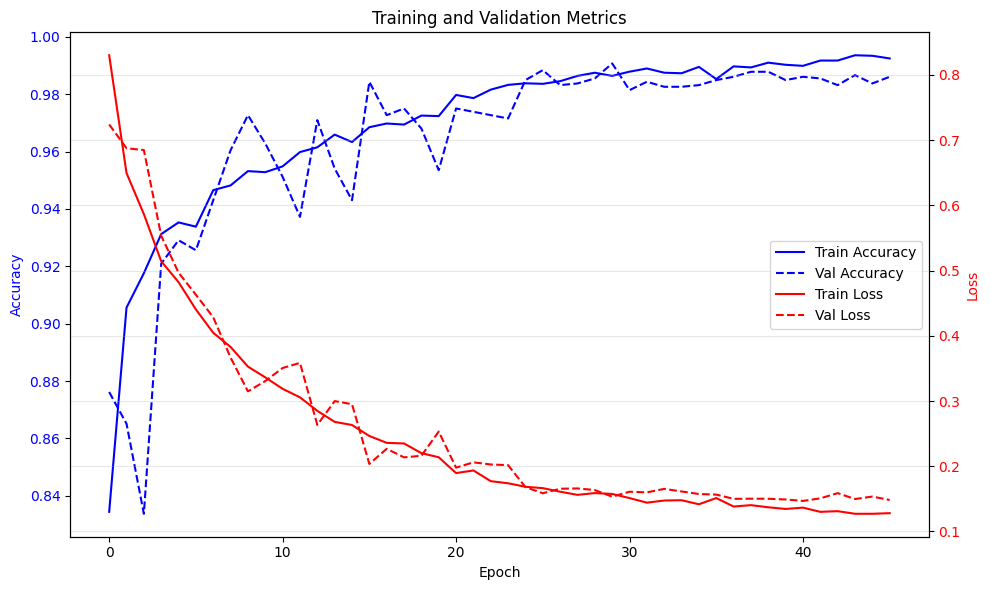

In [18]:
model_resnet8.compile(optimizer=optimizers.Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', metrics.AUC(name='auc')])

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_auc',
    mode='max',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

early_stop = callbacks.EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

checkpoint = callbacks.ModelCheckpoint(
    filepath=r'trained_models_wake_word\resnet8_wake_word.keras',
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    verbose=1
)

resnet8_history = model_resnet8.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=100,
    callbacks=[early_stop, checkpoint, reduce_lr]   )
plot_history(resnet8_history)

Epoch 1/100


166/170 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - Precision: 0.5663 - Recall: 0.4131 - accuracy: 0.7550 - auc: 0.7736 - loss: 1.4233
Epoch 1: val_auc improved from -inf to 0.95549, saving model to trained_models_wake_word\resnet14_wake_word.keras
170/170 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - Precision: 0.5697 - Recall: 0.4193 - accuracy: 0.7568 - auc: 0.7767 - loss: 1.4192 - val_Precision: 0.2803 - val_Recall: 0.9828 - val_accuracy: 0.7430 - val_auc: 0.9555 - val_loss: 1.2795 - learning_rate: 5.0000e-04
Epoch 2/100
167/170 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - Precision: 0.7486 - Recall: 0.8653 - accuracy: 0.8775 - auc: 0.9421 - loss: 1.0750
Epoch 2: val_auc improved from 0.95549 to 0.98407, saving model to trained_models_wake_word\resnet14_wake_word.keras
170/170 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - Precision: 0.7491 - Recall: 0.8652 - accuracy: 0.8779 - auc: 0.9423 - loss: 1.0740 - val_Precision: 0.3107 - val_Recall: 1.0000 - val_accuracy: 0.7756 - val_auc: 0.9841 - val_loss: 1.1576 - learning

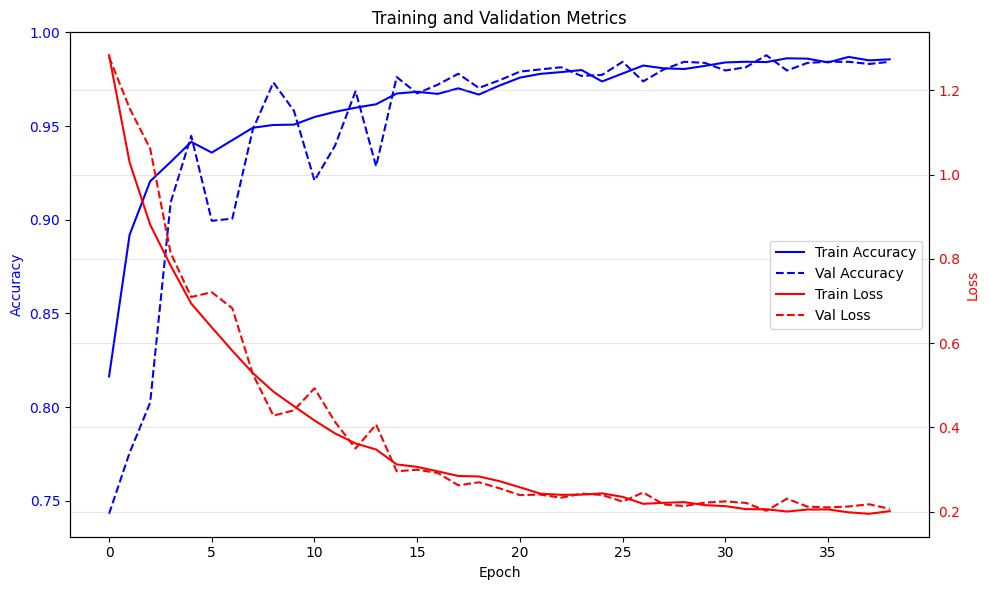

In [19]:
model_resnet14.compile(optimizer=optimizers.Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', metrics.AUC(name='auc')])

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_auc',
    mode='max',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

early_stop = callbacks.EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

checkpoint = callbacks.ModelCheckpoint(
    filepath=r'trained_models_wake_word\resnet14_wake_word.keras',
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    verbose=1
)

resnet14_history = model_resnet14.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=100,
    callbacks=[early_stop, checkpoint, reduce_lr]    )
plot_history(resnet14_history)

Epoch 1/100
169/170 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - Precision: 0.8312 - Recall: 0.8061 - accuracy: 0.9057 - auc: 0.9474 - loss: 0.2763
Epoch 1: val_auc improved from -inf to 0.98480, saving model to trained_models_wake_word\matchboxnet_wake_word.keras
170/170 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - Precision: 0.8319 - Recall: 0.8071 - accuracy: 0.9061 - auc: 0.9477 - loss: 0.2752 - val_Precision: 0.1118 - val_Recall: 1.0000 - val_accuracy: 0.1959 - val_auc: 0.9848 - val_loss: 1.2610 - learning_rate: 5.0000e-04
Epoch 2/100
170/170 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - Precision: 0.9405 - Recall: 0.9521 - accuracy: 0.9701 - auc: 0.9939 - loss: 0.0811
Epoch 2: val_auc improved from 0.98480 to 0.99057, saving model to trained_models_wake_word\matchboxnet_wake_word.keras
170/170 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - Precision: 0.9405 - Recall: 0.9521 - accuracy: 0.9702 - auc: 0.9939 - loss: 0.0810 - val_Precision: 0.6721 - val_Recall: 0.9425 - val_accuracy: 0.9477 - val_auc: 0.9906 - val_loss:

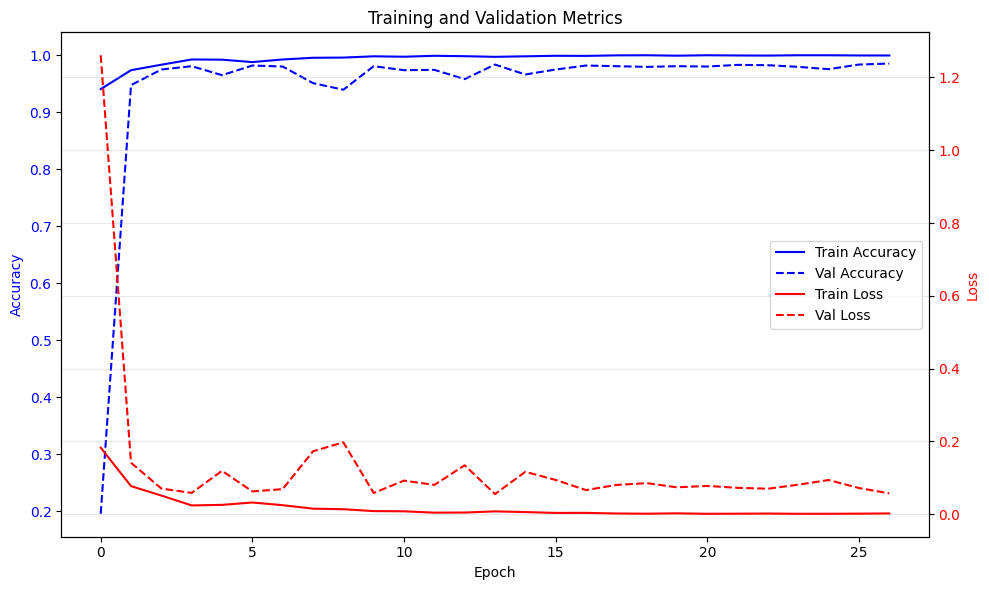

In [20]:
model_matchboxnet.compile(optimizer=optimizers.Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy', 'Precision', 'Recall', metrics.AUC(name='auc')])

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_auc',
    mode='max',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

early_stop = callbacks.EarlyStopping(
    monitor='val_auc',
    mode='max',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

checkpoint = callbacks.ModelCheckpoint(
    filepath=r'trained_models_wake_word\matchboxnet_wake_word.keras',
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    verbose=1
)

matchboxnet_history = model_matchboxnet.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=100,
    callbacks=[early_stop, checkpoint, reduce_lr]   )
plot_history(matchboxnet_history)